**Extracting necessary libraries.**

In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')


**The process of reading the Excel file:**

In [359]:
data = pd.read_excel('MO14-Round-1-Dealing-With-Data-Workbook.xlsx', sheet_name='Usage')
data.head()

,3 PM Mon 24th-Mar-2014___0.384 kwh
0,5AM 15-Aug-2014___1.201 kwh
1,__8PM Thu 20-Mar-2014____1.523 kwh
2,6PM 23rd-Apr-2014___0.424 kwh
3,_1AM Friday 19th-Dec-2014___0.209 kwh
4,_5AM Tue 19th-Aug-2014___1.228 kwh


**While reading the data, one of the rows is assigned as the column name. For this reason, I use the pd.concat method to add the column name to the row.**

In [360]:
row = data.columns[0]

In [361]:
data.rename(columns={data.columns[0]:'info'},inplace=True)

In [362]:
fake = pd.DataFrame({'info':[row]})

In [363]:
df = pd.concat([fake,data],axis=0).reset_index(drop=True)

In [364]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   info    8760 non-null   object
dtypes: object(1)
memory usage: 68.6+ KB


**As for the other text description, I'm looking for a method on how to clean the data with the meta character of the regex library, with some trial and error.**

In [365]:
txt = data.iloc[1,0]
print(txt)

__8PM Thu 20-Mar-2014____1.523 kwh  


In [366]:
re.findall(r"(\d+[A-Z]+)\D+(\d+\D+\d+)\D+(\d+\D\d+)",txt)

[('8PM', '20-Mar-2014', '1.523')]

In [181]:
txt2 = data.iloc[2,0]
print(txt2)

  6PM  23rd-Apr-2014___0.424  kwh


In [367]:
re.findall(r"(\d+[A-Z]+)\D+(\d+\D+\d+)\D+(\d+\D\d+)",txt2)

[('6PM', '23rd-Apr-2014', '0.424')]

In [368]:
re.findall(r"(\d+[A-Z]+)\D+(\d+\D+\d+)\D+(\d+\D\d+)",txt2)

[('6PM', '23rd-Apr-2014', '0.424')]

In [369]:
txt3 = '__2 AM Tuesday 8th-Apr-2014___0.052 kwh'

In [370]:
re.findall(r"(\d+\s[A-Z]+)\D+(\d+\D+\d+)\D+(\d+\D\d+)",txt3)

[('2 AM', '8th-Apr-2014', '0.052')]

**I decided that some of the patterns I tried were suitable for use and created a function and applied it to the dataframe. 3 different patterns are seen. Because especially the hour can be caught when there is an underscore before it, but it cannot be caught when it is alone. I could not extract the days directly.**

In [371]:
def extract_info(info_str):
    pattern = r'(\d+[a-zA-Z]{2})\D+(\d+\D+\d+)\D+(\d+\D\d+)'
    pattern_2 = r'(\d+[A-Z]{2})\D+(\w\w\w)\D+(\d+\D+\d+)\D+(\d+\D\d+)'
    try:
        match_1 = re.search(pattern, info_str)
        if match_1:
            return match_1.groups()
        match_2 = re.search(pattern_2, info_str)
        if match_2:
            return match_2.groups()
        match_3 = re.search(r'(\d+\s[A-Z]{2})\D+(\d+\D+\d+)\D+(\d+\D\d+)', info_str)
        if match_3:
            return match_3.groups()
    except:
        return [None, None, None, None] # Ensure consistency

df[['time', 'date', 'usage']] = df['info'].apply(lambda x: pd.Series(extract_info(x)))

df.head()

,info,time,date,usage
0,3 PM Mon 24th-Mar-2014___0.384 kwh,3 PM,24th-Mar-2014,0.384
1,5AM 15-Aug-2014___1.201 kwh,5AM,15-Aug-2014,1.201
2,__8PM Thu 20-Mar-2014____1.523 kwh,8PM,20-Mar-2014,1.523
3,6PM 23rd-Apr-2014___0.424 kwh,6PM,23rd-Apr-2014,0.424
4,_1AM Friday 19th-Dec-2014___0.209 kwh,1AM,19th-Dec-2014,0.209


In [372]:
df.isnull().sum()

info     0
time     0
date     0
usage    0
dtype: int64

**Date data consists of two types of data: with and without appendixes. Since this is a problem for the pd.to_datatime method, I wrote a function to remove the appendixes.**

In [373]:
def remove_suffix(date_str):
  return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)

df['date'] = df['date'].apply(remove_suffix)

df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y', errors='coerce')

df

,info,time,date,usage
0,3 PM Mon 24th-Mar-2014___0.384 kwh,3 PM,2014-03-24,0.384
1,5AM 15-Aug-2014___1.201 kwh,5AM,2014-08-15,1.201
2,__8PM Thu 20-Mar-2014____1.523 kwh,8PM,2014-03-20,1.523
3,6PM 23rd-Apr-2014___0.424 kwh,6PM,2014-04-23,0.424
4,_1AM Friday 19th-Dec-2014___0.209 kwh,1AM,2014-12-19,0.209
...,...,...,...,...
8755,_1AM Fri 07th-Nov-2014_0.084 kwh,1AM,2014-11-07,0.084
8756,_6AM 20-May-2014__1.027 kwh,6AM,2014-05-20,1.027
8757,__2 AM Tuesday 8th-Apr-2014___0.052 kwh,2 AM,2014-04-08,0.052
8758,9 PM 27th-Jan-2014_1.428 kwh,9 PM,2014-01-27,1.428


**After this, we can apply pandas methods to find the days of the week without any difficulty.**

In [374]:
df['day'] = df['date'].dt.strftime('%A')

df

,info,time,date,usage,day
0,3 PM Mon 24th-Mar-2014___0.384 kwh,3 PM,2014-03-24,0.384,Monday
1,5AM 15-Aug-2014___1.201 kwh,5AM,2014-08-15,1.201,Friday
2,__8PM Thu 20-Mar-2014____1.523 kwh,8PM,2014-03-20,1.523,Thursday
3,6PM 23rd-Apr-2014___0.424 kwh,6PM,2014-04-23,0.424,Wednesday
4,_1AM Friday 19th-Dec-2014___0.209 kwh,1AM,2014-12-19,0.209,Friday
...,...,...,...,...,...
8755,_1AM Fri 07th-Nov-2014_0.084 kwh,1AM,2014-11-07,0.084,Friday
8756,_6AM 20-May-2014__1.027 kwh,6AM,2014-05-20,1.027,Tuesday
8757,__2 AM Tuesday 8th-Apr-2014___0.052 kwh,2 AM,2014-04-08,0.052,Tuesday
8758,9 PM 27th-Jan-2014_1.428 kwh,9 PM,2014-01-27,1.428,Monday


**I wanted to convert the time to 24-hour clock. However, the time data contained phrases such as PM and AM. However, the numbers and letters were adjacent. I had to correct these. I opened a for loop and wrote a small if-else block considering three different situations. Then I converted the data to 24-hour clock type and added it to the dataframe.**

In [376]:
time = []
for i in df['time']:
  parts = i.split()
  if len(parts) > 1 and parts[1] in ('PM', 'AM'):
    time.append(i)
  elif len(parts) == 1 and i[1:] == 'AM' or i[1:] == 'PM':
    i = i[0] + " " + i[1:]
    time.append(i)
  elif len(parts) == 1 and i[2:] == 'AM' or i[2:] == 'PM':
    i = i[0:2] + " " + i[2:]
    time.append(i)
  else:
    time.append(i)

In [377]:
time[:20]

['3 PM',
 '5 AM',
 '8 PM',
 '6 PM',
 '1 AM',
 '5 AM',
 '12 PM',
 '7 AM',
 '8 AM',
 '4 PM',
 '4 PM',
 '1 AM',
 '12 AM',
 '8 PM',
 '3 AM',
 '11 PM',
 '7 PM',
 '1 AM',
 '8 PM',
 '12 PM']

In [378]:
df['time'] = time

In [379]:
df.head(15)

,info,time,date,usage,day
0,3 PM Mon 24th-Mar-2014___0.384 kwh,3 PM,2014-03-24,0.384,Monday
1,5AM 15-Aug-2014___1.201 kwh,5 AM,2014-08-15,1.201,Friday
2,__8PM Thu 20-Mar-2014____1.523 kwh,8 PM,2014-03-20,1.523,Thursday
3,6PM 23rd-Apr-2014___0.424 kwh,6 PM,2014-04-23,0.424,Wednesday
4,_1AM Friday 19th-Dec-2014___0.209 kwh,1 AM,2014-12-19,0.209,Friday
5,_5AM Tue 19th-Aug-2014___1.228 kwh,5 AM,2014-08-19,1.228,Tuesday
6,12PM Mon 7th-Jul-2014___1.296 kwh,12 PM,2014-07-07,1.296,Monday
7,7 AM Tue 25-Nov-2014__0.437 kwh,7 AM,2014-11-25,0.437,Tuesday
8,_8AM 14-Aug-2014__0.523 kwh,8 AM,2014-08-14,0.523,Thursday
9,__4PM 25th-Jan-2014__2.052kwh,4 PM,2014-01-25,2.052,Saturday


In [380]:
df['time'] = pd.to_datetime(df['time'], format='%I %p').dt.strftime('%H:%M')

df

,info,time,date,usage,day
0,3 PM Mon 24th-Mar-2014___0.384 kwh,15:00,2014-03-24,0.384,Monday
1,5AM 15-Aug-2014___1.201 kwh,05:00,2014-08-15,1.201,Friday
2,__8PM Thu 20-Mar-2014____1.523 kwh,20:00,2014-03-20,1.523,Thursday
3,6PM 23rd-Apr-2014___0.424 kwh,18:00,2014-04-23,0.424,Wednesday
4,_1AM Friday 19th-Dec-2014___0.209 kwh,01:00,2014-12-19,0.209,Friday
...,...,...,...,...,...
8755,_1AM Fri 07th-Nov-2014_0.084 kwh,01:00,2014-11-07,0.084,Friday
8756,_6AM 20-May-2014__1.027 kwh,06:00,2014-05-20,1.027,Tuesday
8757,__2 AM Tuesday 8th-Apr-2014___0.052 kwh,02:00,2014-04-08,0.052,Tuesday
8758,9 PM 27th-Jan-2014_1.428 kwh,21:00,2014-01-27,1.428,Monday


In [381]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   info    8760 non-null   object        
 1   time    8760 non-null   object        
 2   date    8760 non-null   datetime64[ns]
 3   usage   8760 non-null   object        
 4   day     8760 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 342.3+ KB


**I converted the usage data to float type so that I can perform mathematical operations.**

In [387]:
df['usage'] = df['usage'].astype(float)
df.tail()


,time,date,usage,day
8755,01:00,2014-11-07,0.084,Friday
8756,06:00,2014-05-20,1.027,Tuesday
8757,02:00,2014-04-08,0.052,Tuesday
8758,21:00,2014-01-27,1.428,Monday
8759,12:00,2014-08-25,0.528,Monday


**İ cleaned the unnecessary data**

In [383]:
df.drop('info',axis=1,inplace=True)
df.head()

,time,date,usage,day
0,15:00,2014-03-24,0.384,Monday
1,05:00,2014-08-15,1.201,Friday
2,20:00,2014-03-20,1.523,Thursday
3,18:00,2014-04-23,0.424,Wednesday
4,01:00,2014-12-19,0.209,Friday


In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8760 non-null   object        
 1   date    8760 non-null   datetime64[ns]
 2   usage   8760 non-null   float64       
 3   day     8760 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 273.9+ KB


*I sorted the data by date*

In [390]:
df = df.sort_values(by=['date','time']).reset_index(drop=True)
df.head()

,time,date,usage,day
0,00:00,2014-01-01,0.684,Wednesday
1,01:00,2014-01-01,0.340,Wednesday
2,02:00,2014-01-01,0.332,Wednesday
3,03:00,2014-01-01,0.396,Wednesday
4,04:00,2014-01-01,0.388,Wednesday


In [395]:
new_df = df.copy()

**In this section, I group the data in different ways and try new data variations.**

In [402]:
grouped = new_df.groupby(['date', 'day', 'time'])['usage'].sum()

grouped.head(48)

date        day        time 
2014-01-01  Wednesday  00:00    0.684
                       01:00    0.340
                       02:00    0.332
                       03:00    0.396
                       04:00    0.388
                       05:00    2.354
                       06:00    2.304
                       07:00    1.530
                       08:00    0.656
                       09:00    0.510
                       10:00    0.952
                       11:00    0.830
                       12:00    0.800
                       13:00    0.784
                       14:00    0.872
                       15:00    0.720
                       16:00    0.936
                       17:00    2.548
                       18:00    2.856
                       19:00    4.248
                       20:00    3.200
                       21:00    1.404
                       22:00    1.200
                       23:00    1.130
2014-01-02  Thursday   00:00    0.690
                     

In [403]:
grouped = grouped.reset_index()

grouped.head()

,date,day,time,usage
0,2014-01-01,Wednesday,00:00,0.684
1,2014-01-01,Wednesday,01:00,0.340
2,2014-01-01,Wednesday,02:00,0.332
3,2014-01-01,Wednesday,03:00,0.396
4,2014-01-01,Wednesday,04:00,0.388


In [423]:
max_date = grouped.groupby('date')['usage'].max().sort_values(ascending=False)
min_date = grouped.groupby('date')['usage'].min().sort_values(ascending=True)
max_day = grouped.groupby('day')['usage'].max().sort_values(ascending=False)
max_time = grouped.groupby('time')['usage'].max().sort_values(ascending=False)

In [420]:
max_date.head(10)

date
2014-07-27    5.141
2014-07-26    5.141
2014-07-20    5.141
2014-07-19    5.054
2014-07-30    5.054
2014-07-07    5.054
2014-07-28    5.011
2014-07-25    4.925
2014-07-13    4.925
2014-07-11    4.882
Name: usage, dtype: float64

# QUESTIONS




**Average hourly electricity usage**






In [441]:
grouped.groupby('time')['usage'].mean().mean()

0.7818779680365296

*I got the names of the months as per the second question.*

In [444]:
grouped['month'] = grouped['date'].dt.month_name()

In [467]:
grouped

,date,day,time,usage,month,days
0,2014-01-01,Wednesday,00:00,0.684,January,1
1,2014-01-01,Wednesday,01:00,0.340,January,1
2,2014-01-01,Wednesday,02:00,0.332,January,1
3,2014-01-01,Wednesday,03:00,0.396,January,1
4,2014-01-01,Wednesday,04:00,0.388,January,1
...,...,...,...,...,...,...
8755,2014-12-31,Wednesday,19:00,1.940,December,31
8756,2014-12-31,Wednesday,20:00,1.901,December,31
8757,2014-12-31,Wednesday,21:00,0.766,December,31
8758,2014-12-31,Wednesday,22:00,0.633,December,31


In [464]:
grouped['days'] = grouped['date'].dt.day

**Average electricity usage per hour months**

In [526]:
grouped.groupby('month')['usage'].mean()

month
April        0.210058
August       0.851331
December     0.764434
February     0.832915
January      1.401425
July         1.687532
June         1.255899
March        0.565522
May          0.560695
November     0.322806
October      0.421665
September    0.485675
Name: usage, dtype: float64

In [527]:
grouped[grouped['month']=='February'].groupby('month')['usage'].mean()

month
February    0.832915
Name: usage, dtype: float64

**Average usage day of the week**

In [521]:
grouped.groupby('day')['usage'].mean().sort_values(ascending=False)

day
Sunday       0.898157
Saturday     0.890764
Friday       0.753744
Thursday     0.745458
Wednesday    0.733943
Tuesday      0.726058
Monday       0.725945
Name: usage, dtype: float64

**Simple Graphics**

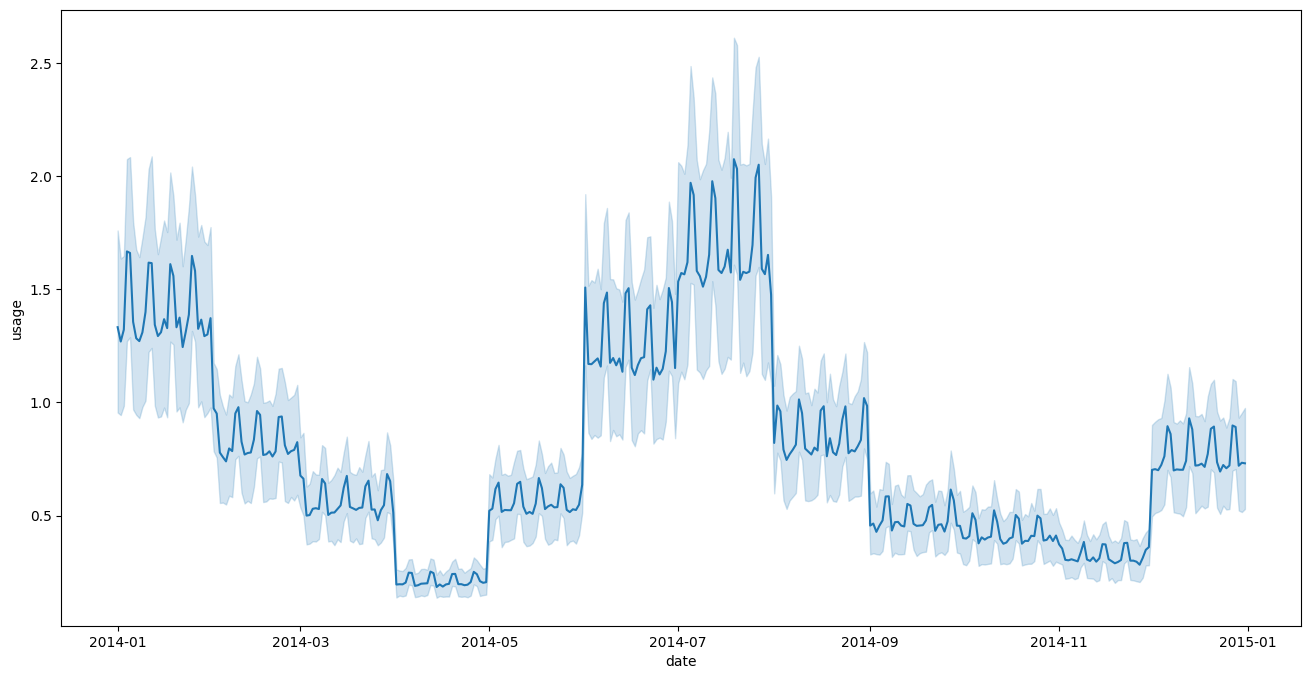

In [416]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='date',y='usage',data=grouped)
plt.show()

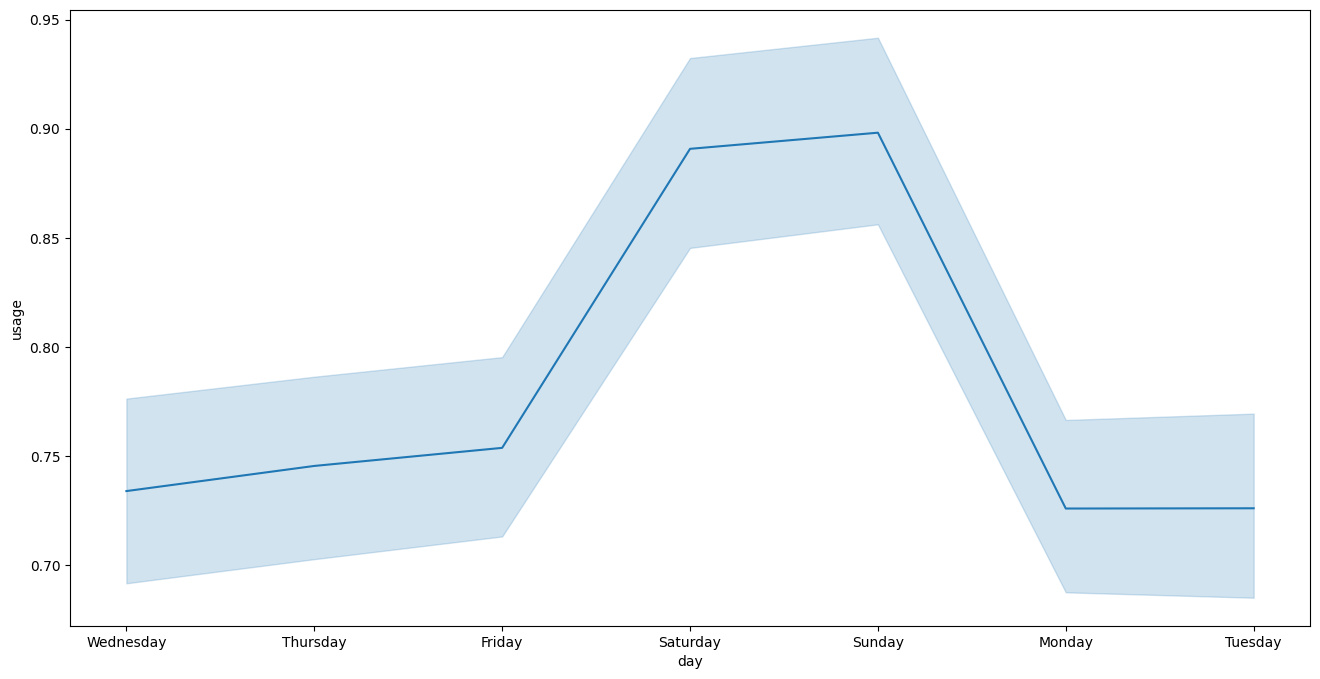

In [415]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='day',y='usage',data=grouped)
plt.show()

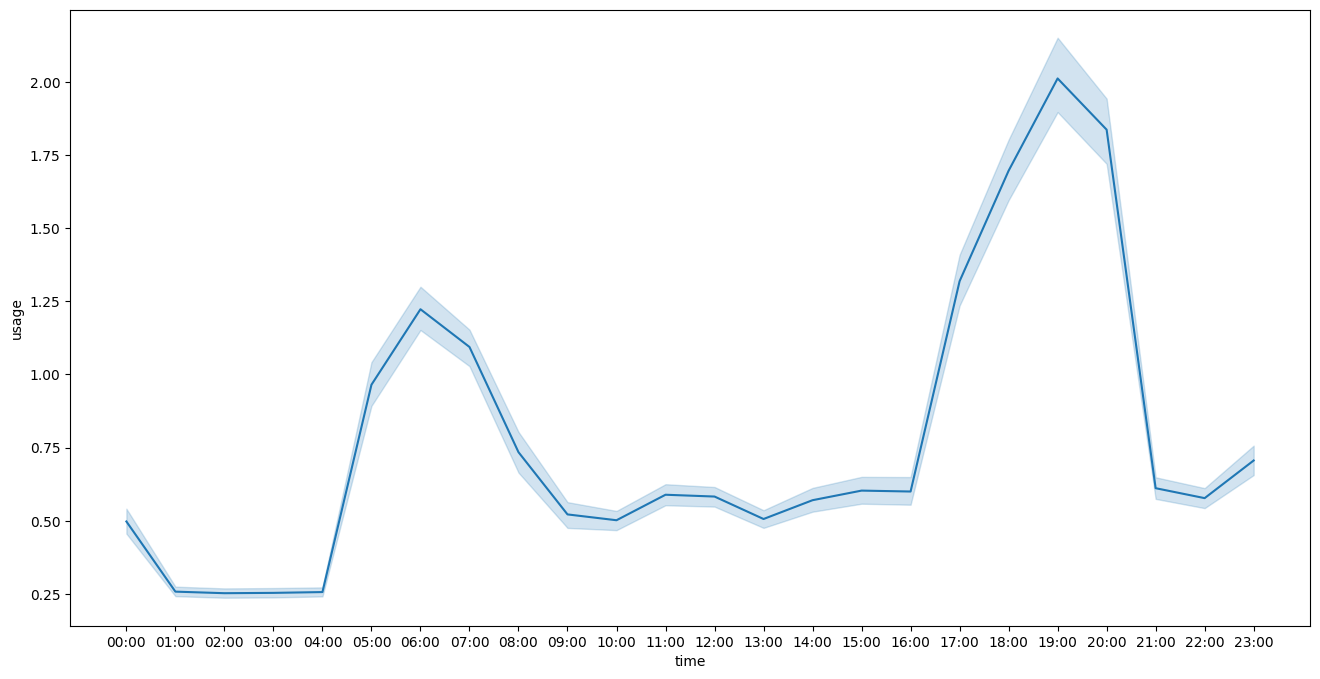

In [414]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='time',y='usage',data=grouped)
plt.show()